In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [8]:
def load_data(type, file_type):
    path = f"dataset/{type}/{file_type}.csv"
    df = pd.read_csv(
        path, 
        encoding="utf-8",
        low_memory=False,
        dtype=int)
    
    df["label"] = 1 if file_type == "A1" else 0
    return df

In [9]:
train_dfs_A1 = load_data("train", "A1")
train_dfs_A2 = load_data("train", "A2")

df_train = pd.concat([train_dfs_A1, train_dfs_A2], ignore_index=True)

df_a1_test = load_data("test", "A1")
df_a2_test = load_data("test", "A2")

# Combine into one DataFrame for testing
df_test = pd.concat([df_a1_test, df_a2_test], ignore_index=True)

# shuffle
df_train = df_train.sample(frac=1, random_state=42)
df_test = df_test.sample(frac=1, random_state=42)

cols = [col for col in df_train.columns if (col != '發生日期' and col != "label")]

df_train = df_train.dropna(how='any')
df_test = df_test.dropna(how='any')

X_train = df_train[cols]
y_train = df_train["label"]

X_test = df_test[cols]
y_test = df_test["label"]

In [10]:
# Print original class distribution
print("Original distribution:", Counter(y_train))

# Oversample the training data
ros = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = ros.fit_resample(X_train, y_train)
X_test, y_test = ros.fit_resample(X_test, y_test)

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Check the new class distribution
print("Resampled distribution:", Counter(y_train))


Original distribution: Counter({0: 1108672, 1: 7279})
Resampled distribution: Counter({0: 1108672, 1: 1108672})


In [11]:
n_clusters = 2  # We assume 2 clusters, one for A1 and one for A2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters_train = kmeans.fit_predict(X_train_normalized)

# -------------------------------
# Map each cluster to a label based on majority vote
# -------------------------------
cluster_label_mapping = {}
for cluster in np.unique(clusters_train):
    # Get indices of training samples in the cluster
    indices = np.where(clusters_train == cluster)[0]
    # Count labels in this cluster
    label_counts = Counter(y_train[indices])
    # Determine the majority label in this cluster
    majority_label = label_counts.most_common(1)[0][0]
    cluster_label_mapping[cluster] = majority_label

print("Cluster to Label Mapping:", cluster_label_mapping)

# -------------------------------
# Use the clustering model to predict clusters for X_test
# -------------------------------
clusters_test = kmeans.predict(X_test_normalized)

# Map cluster labels to the final predicted class
y_pred = np.array([cluster_label_mapping[cluster] for cluster in clusters_test])

# -------------------------------
# (Optional) Evaluate performance if true labels y_test are available
# -------------------------------
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=["A2 (Injury)", "A1 (Fatal)"]))

Cluster to Label Mapping: {np.int32(0): 1, np.int32(1): 0}
              precision    recall  f1-score   support

 A2 (Injury)       0.77      0.18      0.29    475146
  A1 (Fatal)       0.54      0.95      0.68    475146

    accuracy                           0.56    950292
   macro avg       0.65      0.56      0.49    950292
weighted avg       0.65      0.56      0.49    950292



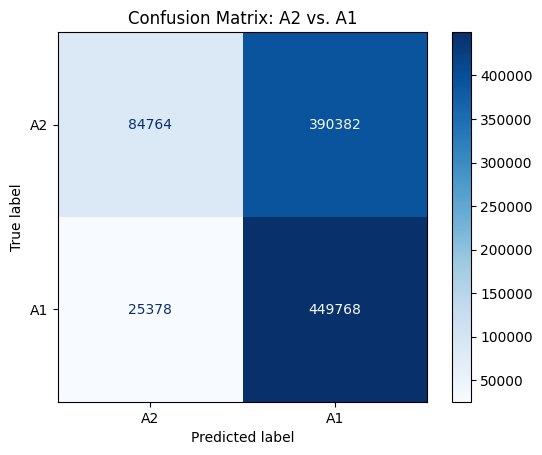

In [12]:
# 1. Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 2. Create a display object, optionally passing in class names
#    Here we assume label=0 -> A2, label=1 -> A1
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["A2", "A1"])

# 3. Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: A2 vs. A1")
plt.show()